# アンサンブル学習　ランダムフォレスト　バギングを学ぼう

## 目的
複数のモデルを組み合わせて予測精度を高める「アンサンブル学習」の中でも、  
**ランダムフォレスト**と**バギング（Bagging）**の基本的な考え方と違いを理解する。  
それぞれの仕組み・長所・短所を学ぶことで、実務における適切なモデル選択につなげる。

---

## ランダムフォレスト

### 概要
ランダムフォレスト（Random Forest）は、**決定木を多数組み合わせたアンサンブル学習手法**。  
それぞれの決定木がデータの一部と特徴量の一部を使って学習し、  
最終的に「多数決（分類）」または「平均（回帰）」によって予測を行う。  

→ **「ランダム性」×「多数の木」**により、過学習を抑え、汎化性能を高める。

---

### 仕組み
1. **データのサンプリング**  
   学習データからブートストラップ法（復元抽出）でランダムにサンプルを生成する。  

2. **特徴量のサンプリング**  
   各決定木の分岐時に、全特徴量の中からランダムに一部だけを候補とする。  

3. **個々の木を学習**  
   サンプリングされたデータと特徴量を用いて、1本の決定木を構築する。  

4. **予測の統合**  
   - 分類：各木の投票結果の多数決  
   - 回帰：各木の予測値の平均  

---

### メリットとデメリット

| 観点 | メリット | デメリット |
|------|-----------|-------------|
| 精度 | 単一の決定木より高い精度を得やすい | 外挿（訓練範囲外の予測）が苦手 |
| 過学習 | バギング＋特徴量ランダム化で過学習を抑制 | 木の数を増やすと学習コスト増大 |
| 解釈性 | 重要度（Feature Importance）で特徴量の寄与を把握可能 | モデル全体の意思決定は「ブラックボックス化」しやすい |
| 処理速度 | 並列化が容易で高速化しやすい | メモリ消費が多くなることがある |

---

## バギング（Bagging）

### 概要
バギング（Bootstrap Aggregating）は、  
**同一アルゴリズムの複数モデルを、異なるサブデータで学習し、結果を平均・多数決で統合する手法。**  
アンサンブル学習の基本形であり、ランダムフォレストの基礎となっている。

---

### 仕組み
1. **ブートストラップ法によるデータ生成**  
   元の学習データから、復元抽出で複数のサブデータセットを作成する。  

2. **各モデルの独立学習**  
   同じ学習アルゴリズム（例：決定木、SVMなど）を、各サブデータに対して学習させる。  

3. **結果の統合**  
   - 分類：多数決（Voting）  
   - 回帰：平均（Averaging）  

→ 各モデルの誤差を打ち消し合い、全体として安定した予測性能を実現。

---

### メリットとデメリット

| 観点 | メリット | デメリット |
|------|-----------|-------------|
| 精度 | ノイズの影響を平均化し、精度を向上 | 各モデルが似すぎると効果が薄い |
| 過学習 | データ分割により過学習を軽減 | 元モデルが高バイアスだと改善しにくい |
| 安定性 | 外れ値やデータのばらつきに強い | 解釈性は低下する |
| 汎用性 | さまざまなアルゴリズムに適用可能 | モデル数に比例して計算量が増加 |

---

## まとめ
- **バギング**は「データを分けて多数のモデルを平均化」する考え方。  
- **ランダムフォレスト**は「バギング＋特徴量のランダム化」により、決定木の弱点を補強した進化形。  

→ どちらも「分散を下げて汎化性能を高める」ことを目的とした手法であり、  
実務でも多くの予測タスク（回帰・分類）で高い性能を発揮する。



# 実データで学ぶ！ランダムフォレストの実装と理解

## 目的
この教材では、実際のデータセットを使って  
**ランダムフォレスト（Random Forest）**の実装・評価・特徴量重要度の可視化を行います。  

今回は有名な **ワイン品質データセット（Wine Quality Dataset）** を使用します。

---

## 1. データセットの概要

### ワイン品質データとは
ワインの化学成分（酸度・糖分・アルコールなど）から、  
品質スコア（0〜10点）を予測するデータセットです。

データは [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/wine+quality) で公開されています。

| 特徴量例 | 説明 |
|-----------|------|
| fixed acidity | 固定酸度 |
| volatile acidity | 揮発酸度 |
| citric acid | クエン酸 |
| residual sugar | 残留糖分 |
| chlorides | 塩化物 |
| alcohol | アルコール度数 |
| quality | 品質スコア（目的変数） |

---



## 2. 必要なライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

3. データの読み込み

In [2]:
# データのダウンロード（URLから直接読み込み）
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')

# 確認
print("データ件数:", df.shape)
df.head()

データ件数: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


4. 前処理

品質スコア（quality）を**「良いワイン（1）」と「そうでない（0）」**に分けて分類問題にします。

In [3]:
# 目標変数の2値化（quality >= 7 を良いワインとする）
df["good"] = (df["quality"] >= 7).astype(int)

# 特徴量と目的変数に分割
X = df.drop(columns=["quality", "good"])
y = df["good"]

# 訓練・テストデータ分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("訓練データ:", X_train.shape)
print("テストデータ:", X_test.shape)

訓練データ: (1119, 11)
テストデータ: (480, 11)


In [4]:
# 5. ランダムフォレストの学習
rf = RandomForestClassifier(
    n_estimators=200,     # 決定木の本数
    max_depth=None,       # 木の深さ制限なし
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("【正解率】", accuracy_score(y_test, y_pred))

【正解率】 0.93125


6. モデル評価

In [5]:
print("\n=== 混同行列 ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== 詳細レポート ===")
print(classification_report(y_test, y_pred, target_names=["Not Good", "Good"]))


=== 混同行列 ===
[[412   3]
 [ 30  35]]

=== 詳細レポート ===
              precision    recall  f1-score   support

    Not Good       0.93      0.99      0.96       415
        Good       0.92      0.54      0.68        65

    accuracy                           0.93       480
   macro avg       0.93      0.77      0.82       480
weighted avg       0.93      0.93      0.92       480



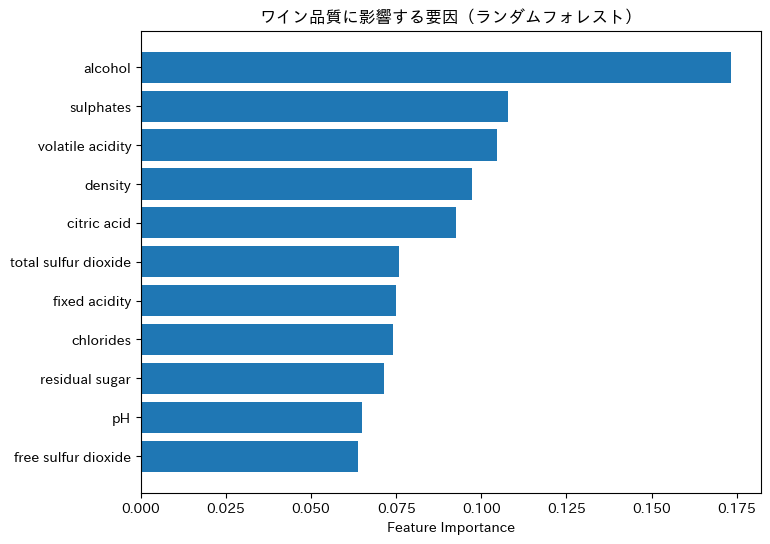

In [6]:
# 7. 特徴量の重要度を可視化
import japanize_matplotlib
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(X.columns[indices], importances[indices])
plt.xlabel("Feature Importance")
plt.title("ワイン品質に影響する要因（ランダムフォレスト）")
plt.show()

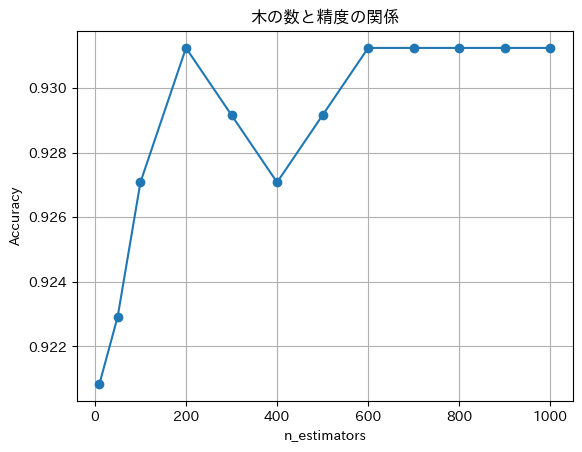

In [7]:
# 8. 木の数（n_estimators）の影響
scores = []
trees = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

for n in trees:
    model = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

plt.plot(trees, scores, marker='o')
plt.title("木の数と精度の関係")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

1. 精度が下がる原因（可能性）
① データ分割・評価のばらつき

交差検証やテストデータで RMSE が変動する場合、サンプルの取り方の影響 で精度が上下することがあります。

特に小規模データやテストデータが限られている場合、木の数が増えることで微妙なランダム差が出やすい。

② 木の相関・過学習の微妙な影響

Random Forest は 複数の木を平均化することで過学習を抑えるのが基本ですが：

木の数が少ないうちはランダム性が高く、偶然うまくいっている場合もある

木を増やすと平均化され、偶然の「うまく当たっていた」効果が薄れることがある

データの特徴によっては、300〜500本の木で少し精度が落ちることもあります。

③ ハイパーパラメータの組み合わせ

max_depth や min_samples_split などの設定次第で、木を増やした際に 過学習や表現力不足 の影響が微妙に出ることがあります。

例えば max_depth が浅い場合、木を増やしても表現力が限られ、逆に過剰に平均化されて精度が少し下がることがあります。

④ 計算誤差やランダム性

scikit-learn では木ごとの学習で サンプルをランダムに抽出します（bootstrap=True がデフォルト）。

木が増えるほど平均化される理屈ですが、特定の乱数シードだと微妙に変動することがあります。

乱数シード (random_state) を固定すると再現性が高くなります。

2. 対策・確認方法

交差検証で安定度を確認

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

trees = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
scores = []

for n in trees:
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    scores.append((-score.mean())**0.5)

import matplotlib.pyplot as plt

plt.plot(trees, scores, marker='o')
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.title("n_estimators vs RMSE")
plt.show()

こうすると 木の数に対するRMSEの傾向が安定的に確認できます。

乱数シードを固定する

RandomForestRegressor(random_state=42) などで再現性を確保

max_depth や min_samples_leaf を見直す

精度が不安定な場合、深さや最小サンプル数を調整すると改善する場合があります。

木を増やしすぎなくてもOK

多くの場合、n_estimators=100〜200 で十分安定することが多いです。

それ以上は計算コストだけ増え、精度改善は限定的。

# 乳がんの判定

# 乳がんデータセット（Breast Cancer Wisconsin Dataset）の概要

## 1. データセットの目的
- 乳房腫瘍（乳がん）の診断を **良性（Benign）か悪性（Malignant）か** に分類することを目的としたデータセット。
- 機械学習の **分類モデル（Classification）** の教材としてよく使用される。

---

## 2. データの構造

- **サンプル数（Observations）**: 569件
- **特徴量（Features）**: 30個（すべて数値データ）
- **ターゲット（Target）**: 2値  
  - 0 = 悪性（Malignant）
  - 1 = 良性（Benign）

---

## 3. 特徴量の種類

特徴量はすべて **腫瘍細胞の顕微鏡画像の測定値** から算出されている。  
代表的な特徴量カテゴリ：

| カテゴリ | 説明 | 例（特徴量） |
|----------|------|-------------|
| **半径（radius）** | 細胞核の大きさの平均 | mean radius, worst radius |
| **テクスチャ（texture）** | グレースケールの標準偏差 | mean texture, worst texture |
| **周の長さ（perimeter）** | 腫瘍の外周の長さ | mean perimeter, worst perimeter |
| **面積（area）** | 腫瘍の面積 | mean area, worst area |
| **滑らかさ（smoothness）** | 表面の滑らかさ | mean smoothness, worst smoothness |
| **コンパクトさ（compactness）** | 輪郭の複雑さ | mean compactness, worst compactness |
| **凹部（concavity）** | 腫瘍の凹んだ部分の程度 | mean concavity, worst concavity |
| **凹部の点数（concave points）** | 凹部の数 | mean concave points, worst concave points |
| **対称性（symmetry）** | 腫瘍の形の対称性 | mean symmetry, worst symmetry |
| **フラクタル次元（fractal dimension）** | 輪郭の複雑さの指標 | mean fractal dimension, worst fractal dimension |

- 各特徴量は **平均（mean）・標準値（se）・最大値（worst）** の3種類の統計量が算出され、合計30特徴量になる。

---

## 4. データの利用例

- **分類モデルの学習**
  - ロジスティック回帰、決定木、ランダムフォレスト、SVM など
- **特徴量の重要度解析**
  - `feature_importances_` や `permutation_importance` の例として使用
- **機械学習の評価指標の練習**
  - 精度（accuracy）、AUC、混同行列（confusion matrix）などの計算

---

## 5. データセットの取得方法（scikit-learn）

```python
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = data.data          # 特徴量 30列
y = data.target        # ターゲット 0=悪性, 1=良性
feature_names = data.feature_names
target_names = data.target_names


正解率: 0.9707602339181286

詳細レポート:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        63
           1       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



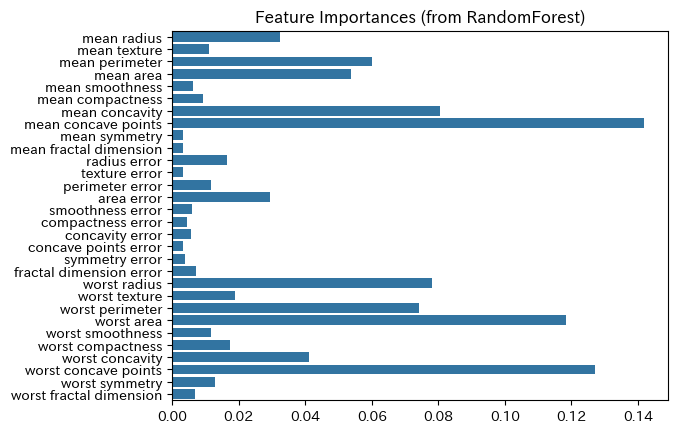

In [8]:
# 1. ライブラリのインポート
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 2. データ読み込み
data = load_breast_cancer()
X, y = data.data, data.target

# 3. 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. モデルの構築
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 5. 予測と評価
y_pred = rf.predict(X_test)
print("正解率:", accuracy_score(y_test, y_pred))
print("\n詳細レポート:\n", classification_report(y_test, y_pred))

# 6. 特徴量重要度（組み込みの feature_importances_）
importances = rf.feature_importances_
features = data.feature_names
sns.barplot(x=importances, y=features)
plt.title("Feature Importances (from RandomForest)")
plt.show()

Permutation Importanceによる特徴量重要度の測定

feature_importances_ は「分岐にどの特徴量が使われたか」に基づく重要度ですが、
より汎化的な重要度評価として「Permutation Importance（特徴量の並べ替え重要度）」を確認します。

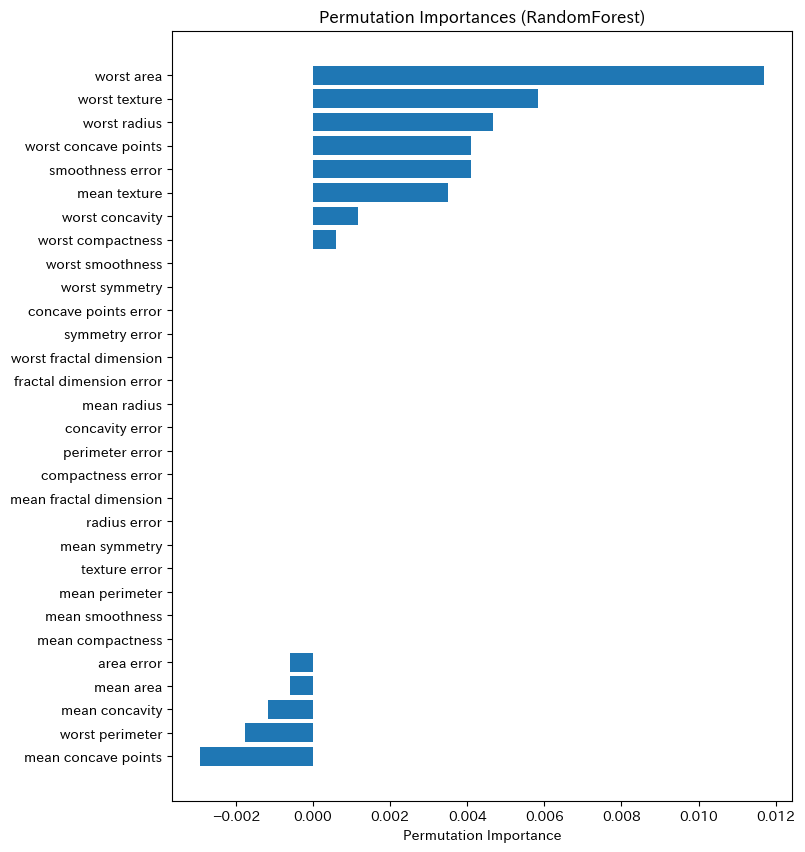

In [9]:
from sklearn.inspection import permutation_importance

# 7. Permutation Importance の計算
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# 結果を可視化
perm_sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(8, 10))
plt.barh(range(len(perm_sorted_idx)), result.importances_mean[perm_sorted_idx])
plt.yticks(range(len(perm_sorted_idx)), [features[i] for i in perm_sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importances (RandomForest)")
plt.show()

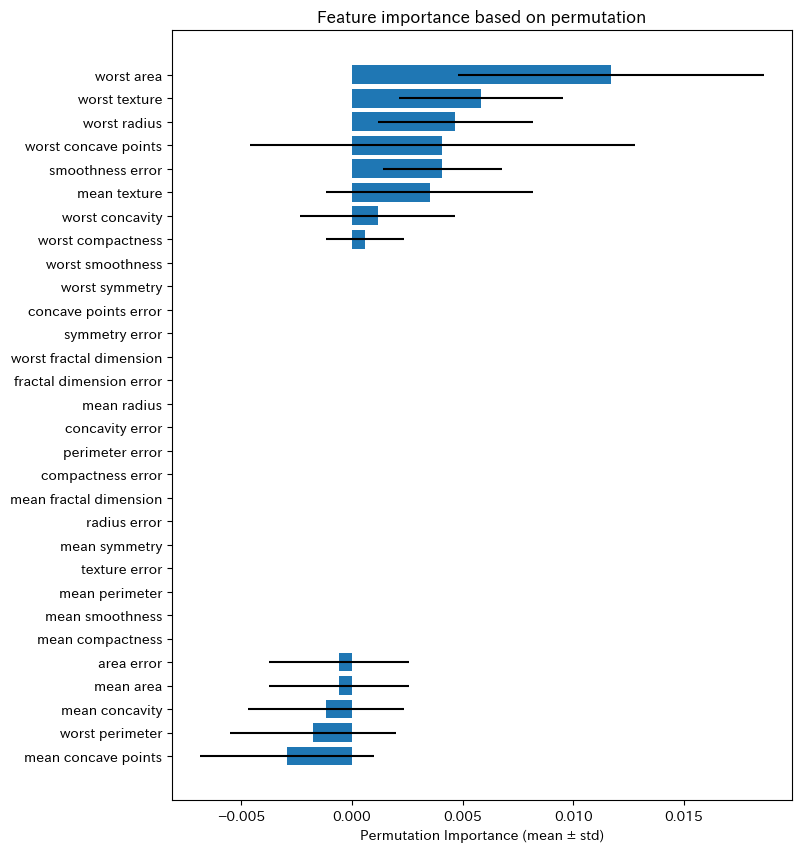

In [10]:
import matplotlib.pyplot as plt

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(8, 10))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx],
         xerr=result.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), [data.feature_names[i] for i in sorted_idx])
plt.xlabel("Permutation Importance (mean ± std)")
plt.title("Feature importance based on permutation")
plt.show()

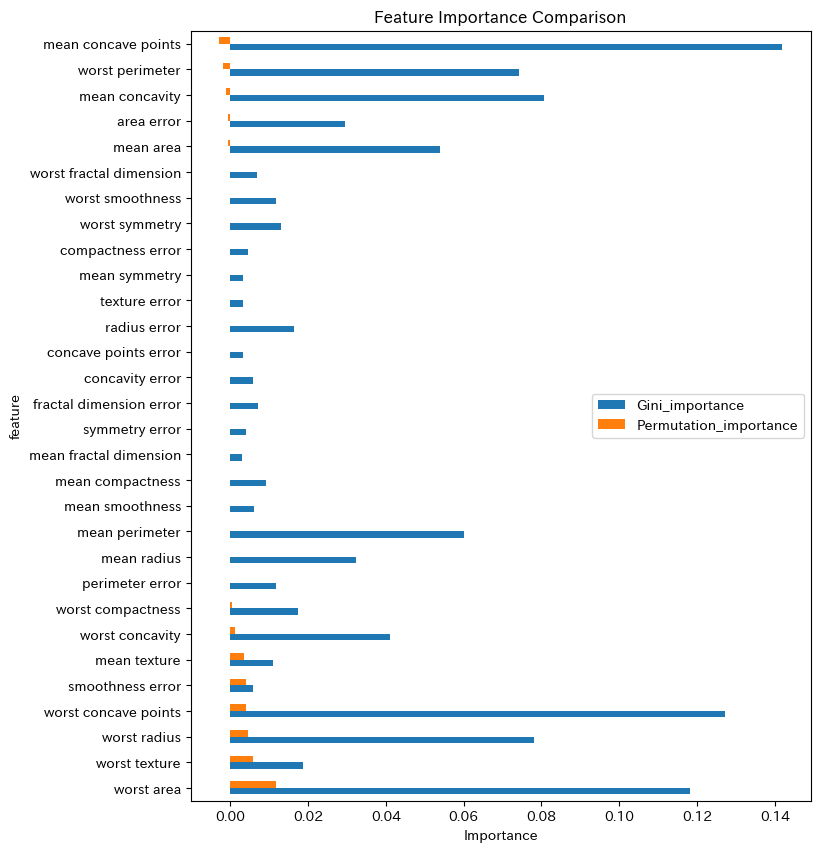

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 各特徴量の重要度をまとめる
df_imp = pd.DataFrame({
    'feature': data.feature_names,
    'Gini_importance': rf.feature_importances_,
    'Permutation_importance': result.importances_mean
}).sort_values('Permutation_importance', ascending=False)

# 棒グラフ比較
df_imp.plot(x='feature', kind='barh', figsize=(8,10))
plt.title('Feature Importance Comparison')
plt.xlabel('Importance')
plt.show()

# feature_importances_ と permutation_importance の違い

## 1. それぞれの概要

| 指標 | 説明 | 算出方法 |
|------|------|-----------|
| **`feature_importances_`（モデル内重要度）** | モデルの構築過程で計算される特徴量の重要度。決定木分割で「どれだけ不純度を減らしたか」に基づく。 | 各特徴量が木の分割時にどれだけ「情報利得（不純度減少）」に貢献したかの総和。 |
| **`permutation_importance`（置換重要度）** | モデル構築後に、特徴量の値をシャッフルして「予測精度がどれだけ悪化するか」を測定。 | 特徴量を1列ずつランダムに入れ替え、スコア（精度）の低下量を計算。 |

---

## 2. スコアの違いが生まれる理由

`feature_importances_`では高いのに、  
`permutation_importance`では低くなることがあります。

### 主な原因

| 原因 | 説明 |
|------|------|
| **① 特徴量間の相関が高い** | 似た特徴量が複数ある場合、ランダムフォレストは両方を「使える」と判断し、分割で使われやすくなる。そのため`feature_importances_`では高く見える。一方、`permutation_importance`では一方をシャッフルしても、もう一方が補完するためスコア低下が小さい。 |
| **② ノイズや冗長な特徴量を含む** | モデルの学習過程では偶然その特徴量が使われることがあり、`feature_importances_`が高くなる場合があるが、予測に実際寄与していないため`permutation_importance`では低い。 |
| **③ モデルが過学習している** | 学習データに強く適合していると、`feature_importances_`は局所的な特徴を高く評価する傾向がある。置換テストではそれが再現されず、重要度が下がる。 |
| **④ 特徴量スケールや分布の偏り** | 決定木はスケール非依存だが、特徴量の分布によって分割回数が偏ることがある。`feature_importances_`はその影響を受けやすい。 |

---

## 3. 実務上の使い分け

| 使用場面 | 推奨指標 | 理由 |
|------------|------------|------|
| モデル内部の挙動理解（どの特徴が多く使われたか） | `feature_importances_` | 学習過程の分割に基づくため、木の「使われ方」を理解できる。 |
| モデル全体の予測寄与を評価（説明性の確認） | `permutation_importance` | モデル外部からの精度劣化で評価するため、より実際の寄与に近い。 |
| 特徴量選択やモデル改善 | `permutation_importance` | 相関・過学習の影響を受けにくく、信頼性が高い。 |

---

## 4. まとめ

- `feature_importances_` は **モデル構造的な重要度**  
- `permutation_importance` は **予測性能への寄与度**  
- 両者の違いが大きい場合は、  
  → 相関関係や冗長特徴量の存在を疑うことが重要。

---

## 5. 可視化例（任意）

```python
import pandas as pd
import matplotlib.pyplot as plt

# 各特徴量の重要度をまとめる
df_imp = pd.DataFrame({
    'feature': data.feature_names,
    'Gini_importance': rf.feature_importances_,
    'Permutation_importance': result.importances_mean
}).sort_values('Permutation_importance', ascending=False)

# 棒グラフ比較
df_imp.plot(x='feature', kind='barh', figsize=(8,10))
plt.title('Feature Importance Comparison')
plt.xlabel('Importance')
plt.show()


# ランダムフォレスト回帰で連続値データを学ぼう

## 1. データセットの概要

### データセット名
- California Housing Dataset（カリフォルニア州住宅価格データ）

### 目的
- 各地区の住宅の中央値価格（MedHouseVal）を **連続値** で予測する。

### サンプル数
- 約20,000件

### 特徴量
- 8つの数値特徴量

| 特徴量 | 説明 |
|--------|------|
| MedInc | 世帯収入の中央値 |
| HouseAge | 住宅の築年数の中央値 |
| AveRooms | 部屋数の平均 |
| AveBedrms | 寝室数の平均 |
| Population | 地区人口 |
| AveOccup | 世帯人数の平均 |
| Latitude | 緯度 |
| Longitude | 経度 |

### 目的変数
- MedHouseVal（住宅価格の中央値, 単位: 100,000ドル）

---

## 2. データ取得方法（scikit-learn）


In [12]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)
X = data.data        # 特徴量 8列
y = data.target      # 住宅価格中央値
feature_names = data.feature_names

In [13]:
y

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

3. ランダムフォレスト回帰の例

RMSE＝0.505　50,500ドル

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ランダムフォレスト回帰モデル
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 予測
y_pred = rf.predict(X_test)

# 精度評価
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"RMSE: {rmse:.3f}")


RMSE: 0.505


4. 特徴量の重要度（feature_importances_）

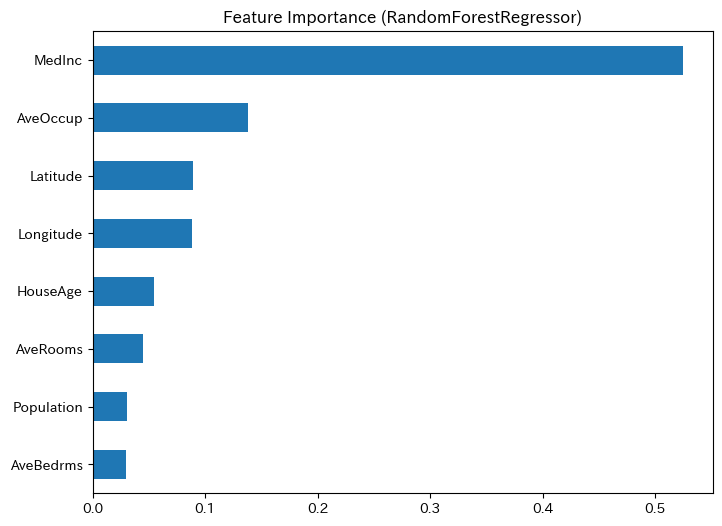

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

importance = pd.Series(rf.feature_importances_, index=feature_names)
importance.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance (RandomForestRegressor)")
plt.show()


5. 置換重要度（Permutation Importance）

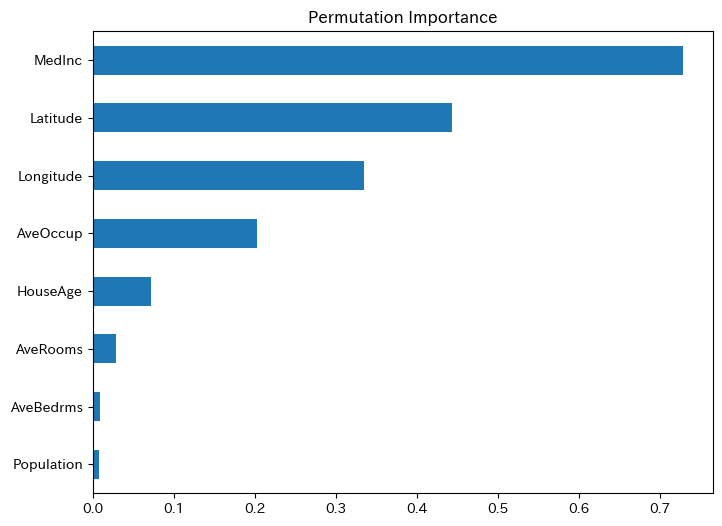

In [16]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

perm_importance = pd.Series(result.importances_mean, index=feature_names)
perm_importance.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Permutation Importance")
plt.show()


# 回帰モデルの精度評価（RMSEとMAPE）

## 1. 精度指標の概要

| 指標 | 意味 | 算出式 |
|------|------|--------|
| **RMSE** | 平均二乗誤差の平方根。誤差の大きさを評価（単位は目的変数と同じ） | \(\sqrt{\frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}\) |
| **MAE** | 平均絶対誤差。誤差の平均を絶対値で評価 | \(\frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|\) |
| **MAPE** | 平均絶対誤差率。実測値に対する誤差の割合を評価 | \(\frac{100}{n}\sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}\) [%] |
| **R²（決定係数）** | モデルがデータをどれだけ説明できているか | \(1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}\) |

---

## 2. Pythonでの計算例

```python
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# MAE
mae = mean_absolute_error(y_test, y_pred)

# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# R²
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.3f}")


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(y_test, y_pred)

# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# R²
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.3f}")

RMSE: 0.505
MAE: 0.328
MAPE: 18.92%
R²: 0.805


回帰モデル精度の評価（例: California Housing Dataset）
1. 指標の確認
| 指標   | 値      | 意味                           |
| ---- | ------ | ---------------------------- |
| RMSE | 0.505  | 平均的に 1件あたり約 50,500ドル程度の誤差    |
| MAE  | 0.328  | 平均絶対誤差が約 32,800ドル程度          |
| MAPE | 18.92% | 実測値に対して平均で約 19% の誤差          |
| R²   | 0.805  | 目的変数の変動の約 80.5% をモデルが説明できている |


2. 評価ポイント

予測誤差の大きさ（RMSE, MAE）

RMSE > MAE なので、大きな誤差（外れ値）が少し影響していることがわかります。

RMSE 0.505 は住宅価格の中央値（単位 10万ドル）で見ると約 50,500ドルの誤差。
→ 平均的にはそこそこの精度ですが、個別の価格予測にはやや誤差が残る。

誤差率（MAPE）

MAPE 18.9% は「平均で約2割のズレ」があることを示す。

実務上、中規模～大規模な住宅価格予測としては 許容範囲内とも言えるが改善の余地あり。

説明力（R²）

R² = 0.805 → モデルがデータの変動の 80% を説明できている

高めの値で、予測モデルとしては十分な説明力がある。

3. 総合評価

全体的に良好

住宅価格の中央値を予測する回帰モデルとしては実用レベル

改善の余地

MAPEが約20%あるので、外れ値や特定地域の住宅価格には誤差が大きい可能性

特徴量の追加やハイパーパラメータ調整でさらに精度向上が期待できる

4. 改善アイデア

特徴量エンジニアリング

緯度・経度から地区情報や人口密度を追加

住宅年齢や世帯構成を工夫して新しい特徴量を作成

モデル調整

RandomForestRegressor の n_estimators, max_depth をチューニング

他のモデル（GradientBoosting, XGBoost, LightGBM）との比較

外れ値対応

RMSE が大きくなりやすい外れ値の影響を軽減するために log変換や Winsorize を検討

# RandomForestRegressor のハイパーパラメータチューニング

## 1. 調整対象のパラメータ

| パラメータ | 意味 | 影響 |
|------------|------|------|
| **n_estimators** | 森に作る決定木の数 | 大きいほど精度は安定するが計算コストが増える |
| **max_depth** | 各決定木の最大深さ | 大きすぎると過学習、小さすぎると精度低下 |

---

## 2. チューニング方法の例

### 2.1 GridSearchCV を使った全探索

```python
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# ハイパーパラメータ候補
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,             # 5分割交差検証
    scoring='neg_mean_squared_error',  # RMSEを評価（小さい誤差が良い）
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_)**0.5)


In [18]:
### 2.1 GridSearchCV を使った全探索

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# ハイパーパラメータ候補
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,             # 5分割交差検証
    scoring='neg_mean_squared_error',  # RMSEを評価（小さい誤差が良い）
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_)**0.5)

Best parameters: {'max_depth': 20, 'n_estimators': 200}
Best RMSE: 0.5103363555417678


In [20]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}")

RMSE: 0.505, MAE: 0.327


2.2 RandomizedSearchCV を使ったランダム探索

候補が多い場合はランダム探索で高速化

In [21]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

param_dist = {
    'n_estimators': stats.randint(50, 300),
    'max_depth': stats.randint(5, 30)
}

rf = RandomForestRegressor(random_state=42)

rand_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,        # ランダム20回探索
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

rand_search.fit(X_train, y_train)

print("Best parameters:", rand_search.best_params_)
print("Best RMSE:", (-rand_search.best_score_)**0.5)

Best parameters: {'max_depth': 26, 'n_estimators': 285}
Best RMSE: 0.5098419555827278


In [22]:
best_rf = rand_search.best_estimator_
y_pred = best_rf.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}")

RMSE: 0.504, MAE: 0.327
